## Attempting to make an N-Link IK solver
##### with validity forward kinematics checker

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from scipy import optimize


# idea is that you have an arm


# class nlink_arm

# so it contains n links:
# list of link lengths
# list of link angles
# x and y coordinates of end effector

minimizer = optimize.minimize

class nlink_arm:
    def __init__(self, n):
        self.n = n
        self.link_lengths = [1] * n
        self.link_angles = [0] * n
        self.x = 0
        self.y = 0
        
    def get_ee_position(self):
        x = 0
        y = 0
        
        # forward kinematics for each link
        for i in range(self.n):
            x += self.link_lengths[i] * math.cos(sum(self.link_angles[:i+1]))
            y += self.link_lengths[i] * math.sin(sum(self.link_angles[:i+1]))
        return (x, y)
    
    
# target is discrete locations along an infinity, x and y lists that make coordinates for this target at each timestep i
target_x = []
target_y = []

# generate target path for arm to move in infinity shape
# for i in range(100):
#     t = i / 100 * 2 * math.pi
#     target_x.append(math.sin(t) * math.cos(t))
#     target_y.append(math.sin(t) * math.sin(t))
    
# infinity shape with 200 points
n = 200
a = 2.0 / math.sqrt(2)  # so that a*sqrt2 = 2.5
for i in range(n):
    t = i/n * 2 * math.pi
    denominator = (math.sin(t)**2 + 1)
    target_x.append(a * math.sqrt(2) * math.cos(t) / denominator)
    target_y.append(a * math.sqrt(2) * math.sin(t) * math.cos(t) / denominator)


    

In [ ]:
# optimization:
# computes forward kinmatics as part of objective function. 

# objective/cost function is distance from target
# takes in a current state (set of angles) + target at the time step, calculates ee position, returns distance from target
# def optimizer(n_link_arm, target_x, target_y):
    
#     def cost_function(angles):
#         n_link_arm.link_angles = angles
#         x, y = n_link_arm.get_ee_position()
#         return math.sqrt((x - target_x) ** 2 + (y - target_y) ** 2)
    
#     # initial guess for angles
#     initial_angles = [0] * n_link_arm.n
    
#     # optimize on this cost function for each time step of our circle
#     result = minimizer(cost_function, initial_angles, method='L-BFGS-B')
    
#     return result.x  # optimized angles


# chat modiyfing the cost function to implement constraints:
def optimizer(n_link_arm, target_x, target_y, theta_prev=None, lambda_reg=0.1):
    def cost_function(angles):
        n_link_arm.link_angles = angles
        x, y = n_link_arm.get_ee_position()
        # distance from target point
        ik_error = math.sqrt((x - target_x) ** 2 + (y - target_y) ** 2)
        
        # minimum angle difference penalty - is this better than using strict constraints?
        if theta_prev is not None:
            smoothness_penalty = sum((angles[i] - theta_prev[i]) ** 2 for i in range(len(angles)))
        else:
            smoothness_penalty = 0
        
        return ik_error + lambda_reg * smoothness_penalty

    initial_angles = theta_prev if theta_prev is not None else [0] * n_link_arm.n
    result = minimizer(cost_function, initial_angles, method='L-BFGS-B')
    return result.x

# optimize on this cost function for each time step of our circle


# question is:
# if i made my own gradient descent optimizer, would it still work - still optimization right?
# good way to learn about optimization

In [3]:
# arm = nlink_arm(6)  # 3-link arm

# arm_path_data = []  # to store arm path data

# for i in range(len(target_x)):
#     target = (target_x[i], target_y[i])
#     optimized_angles = optimizer(arm, target[0], target[1])
#     arm.link_angles = optimized_angles
#     arm.get_ee_position()
    
#     print(f"Target: {target}, Optimized Angles: {optimized_angles}, End Effector Position: {arm.get_ee_position()}")
    


arm = nlink_arm(6)  # 6-link arm

arm_path_data = []
theta_prev = None

for i in range(len(target_x)):
    target = (target_x[i], target_y[i])
    optimized_angles = optimizer(arm, target[0], target[1], theta_prev)
    arm.link_angles = optimized_angles
    theta_prev = optimized_angles
    arm.get_ee_position()
    
    print(f"Target: {target}, Optimized Angles: {optimized_angles}, End Effector Position: {arm.get_ee_position()}")

Target: (0.0, 0.0), Optimized Angles: [0. 0. 0. 0. 0. 0.], End Effector Position: (6.0, 0.0)
Target: (0.06266661678215212, 0.003942649342761085), Optimized Angles: [-0.02274017  0.4506409   0.97746614  1.46426301  1.04897351  0.45182827], End Effector Position: (0.06266638738084873, 0.003942522761035683)
Target: (0.12434494358242741, 0.015708419435684445), Optimized Angles: [-0.02097712  0.43411258  0.956295    1.46742891  1.07660323  0.47237916], End Effector Position: (0.124344941983132, 0.015708417455195134)
Target: (0.18406227634233896, 0.035111757055874285), Optimized Angles: [-0.01843258  0.4167305   0.93276357  1.4682285   1.10449075  0.49381037], End Effector Position: (0.18406226532704517, 0.035111768534338506)
Target: (0.24087683705085763, 0.06184665997806821), Optimized Angles: [-0.0152962   0.39868804  0.90721314  1.46652314  1.13206606  0.5157483 ], End Effector Position: (0.2408768271919896, 0.06184666930842231)
Target: (0.2938926261462365, 0.09549150281252627), Optimized

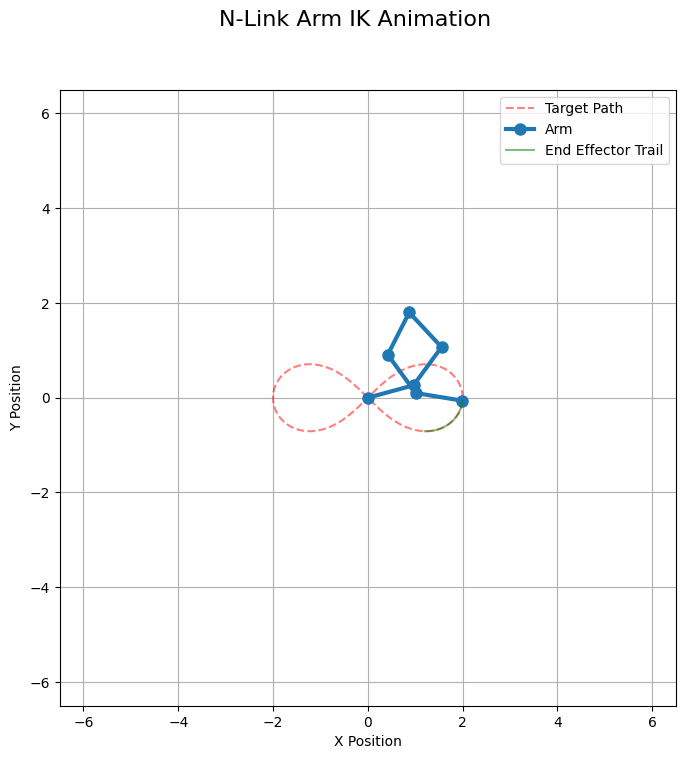

In [11]:
# numerical:
# computs forward kinematic, checks how far it is from the target, nudges it just a bit closer





# Animation of the N-Link Arm following the infinity path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle

# Function to compute all joint positions for visualization
def get_joint_positions(arm):
    """
    Calculate all joint positions for visualization
    Returns lists of x and y coordinates for each joint including the base and end effector
    """
    x_positions = [0]  # Base joint at origin
    y_positions = [0]
    
    cumulative_angle = 0
    cumulative_x = 0
    cumulative_y = 0
    
    for i in range(arm.n):
        cumulative_angle += arm.link_angles[i]
        cumulative_x += arm.link_lengths[i] * np.cos(cumulative_angle)
        cumulative_y += arm.link_lengths[i] * np.sin(cumulative_angle)
        x_positions.append(cumulative_x)
        y_positions.append(cumulative_y)
    
    return x_positions, y_positions

# Initialize arm and run the optimizer for each target point to collect the data
arm = nlink_arm(6)  # 3-link arm with default lengths of 1
theta_prev = None

# Store the path data for animation
arm_frames = []

for i in range(len(target_x)):
    target = (target_x[i], target_y[i])
    optimized_angles = optimizer(arm, target[0], target[1], theta_prev)
    arm.link_angles = optimized_angles
    theta_prev = optimized_angles
    
    # Get all joint positions for this frame
    joint_positions = get_joint_positions(arm)
    
    # Store frame data: joint positions and current target
    arm_frames.append({
        'joint_x': joint_positions[0],
        'joint_y': joint_positions[1],
        'target_x': target[0],
        'target_y': target[1]
    })

# Set up the figure and animation
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('N-Link Arm IK Animation', fontsize=16)

# Set fixed limits to avoid the plot from rescaling during animation
max_arm_reach = arm.n * max(arm.link_lengths)  # Maximum theoretical reach of the arm
ax.set_xlim(-max_arm_reach-0.5, max_arm_reach+0.5)
ax.set_ylim(-max_arm_reach-0.5, max_arm_reach+0.5)
ax.set_aspect('equal')
ax.grid(True)

# Plot the target path (infinity shape)
ax.plot(target_x, target_y, 'r--', alpha=0.5, label='Target Path')

# Initialize objects that will be updated in the animation
arm_line, = ax.plot([], [], 'o-', lw=3, markersize=8, label='Arm')
# target_point = ax.add_patch(Circle((0, 0), 0.05, fc='red', ec='red', label='Current Target'))
ee_trail, = ax.plot([], [], 'g-', alpha=0.5, label='End Effector Trail')

ee_trail_x = []
ee_trail_y = []

# Add a legend
ax.legend(loc='upper right')

# Add axis labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')

# Initialization function for animation
def init():
    arm_line.set_data([], [])
    # target_point.center = (0, 0)
    ee_trail.set_data([], [])
    return arm_line, ee_trail

# Animation function called for each frame
def animate(i):
    frame = arm_frames[i % len(arm_frames)]
    
    # Update arm line
    arm_line.set_data(frame['joint_x'], frame['joint_y'])
    
    # Update target point
    # target_point.center = (frame['target_x'], frame['target_y'])
    
    # Update end effector trail
    ee_trail_x.append(frame['joint_x'][-1])
    ee_trail_y.append(frame['joint_y'][-1])
    
    # Only keep recent positions for trail effect
    if len(ee_trail_x) > 20:  # Adjust for longer or shorter trail
        ee_trail_x.pop(0)
        ee_trail_y.pop(0)
    
    ee_trail.set_data(ee_trail_x, ee_trail_y)
    
    return arm_line, ee_trail

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(arm_frames), 
                             init_func=init, blit=True, interval=100)

# To save the animation (optional, uncomment if needed)
ani.save('nlink_arm_animation.gif', writer='pillow', fps=10)

# plt.show()

In [5]:
print(target_point)

Circle(xy=(-0.0626666, 0.00394265), radius=0.05)


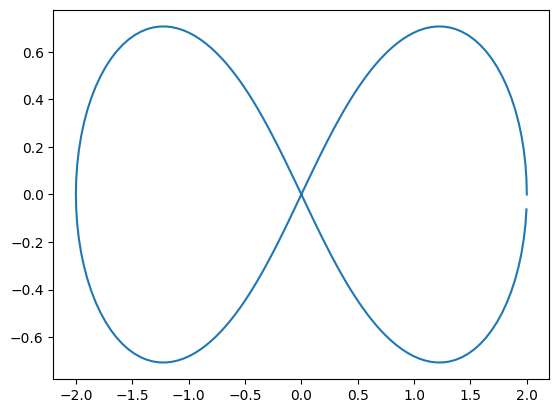

In [10]:
plt.plot(target_x, target_y)